# setup 

what we're going to try to do, build an inception net

make it 2 layers deeper than my deepest conv net

throw it at some gpus, see waht happens, not sure

if i should use a prebaked net with a ton of layers

or do the above with a smaller net. tending towards

using a smaller net that i understand and make myself

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices() 

[name: "/cpu:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10258108280483656675, name: "/gpu:0"
 device_type: "GPU"
 memory_limit: 11332668621
 locality {
   bus_id: 2
 }
 incarnation: 17903993425822209246
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:84:00.0", name: "/gpu:1"
 device_type: "GPU"
 memory_limit: 11330676327
 locality {
   bus_id: 2
 }
 incarnation: 7359599530854234529
 physical_device_desc: "device: 1, name: Tesla K80, pci bus id: 0000:85:00.0"]

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from scipy import ndimage
from scipy import misc

import os, gc, sys, glob
from tqdm import tqdm

from sklearn import model_selection
from sklearn import metrics

from keras import backend as K
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Activation, AveragePooling2D, merge
from keras.layers.normalization import BatchNormalization
from keras.metrics import categorical_accuracy
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Input, GlobalAveragePooling2D, GlobalMaxPooling2D, concatenate
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [3]:
DATA_DIR = os.path.join('/scratch', 'yns207', 'data_invasive')

path = DATA_DIR
test_path = os.path.join(path, 'test')
models_path = os.path.join(path, 'results')
train_path = os.path.join(path, 'train')
valid_path = os.path.join(path, 'valid')
model_name = 'model_jun28_kfold'
print(path)

/scratch/yns207/data_invasive


```
%cd $DATA_DIR
!module load centos/7
!7za x '*.7z'
```

# defining funcs

In [4]:
#gpu parallelization code from https://github.com/fchollet/keras/issues/2436

def slice_batch(x, n_gpus, part):

    sh = K.shape(x)
    L = sh[0] / n_gpus
    if part == n_gpus - 1:
        return x[part*L:]

    return x[part*L:(part+1)*L]

def to_multi_gpu(model, n_gpus=2):

    with tf.device('/cpu:0'):
        x = Input(model.input_shape[1:], name=model.input_names[0])

    towers = []
    for g in range(n_gpus):
        with tf.device('/gpu:' + str(g)):
            slice_g = Lambda(slice_batch, lambda shape: shape,
    arguments={'n_gpus':n_gpus, 'part':g})(x)
            towers.append(model(slice_g))

        with tf.device('/cpu:0'):
            merged = merge(towers, mode='concat', concat_axis=0)

    return Model(input=[x], output=merged)

In [5]:
def grab_optimizer(opt, lr):
    if opt == 'sgd':
        return optimizers.SGD(lr=lr, decay=1e-6, momentum=0.8, nesterov=True)
    elif opt == 'adam':
        return optimizers.Adam(lr=lr)
    elif opt == 'adagrad':
        return optimizers.Adagrad(lr=lr)
    elif opt == 'rmsprop':
        return optimizers.RMSprop(lr=lr)

In [6]:
# this is not a naive inception module, it contains many 1x1 convs
# to reduce dimensionality before the 3x3 and 5x5 convs
def inception_block(filter_depth, inputs):
    t1 = Convolution2D(filter_depth, (1, 1), padding='same', activation='relu',use_bias=False)(inputs)
    tower_1 = Convolution2D(filter_depth, (3, 3), padding='same', activation='relu', use_bias=False)(t1)
    tower_2 = Convolution2D(filter_depth, (5, 5), padding='same', activation='relu', use_bias=False)(t1)
    tower_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    tower_3 = Convolution2D(filter_depth, (1, 1), padding='same', activation='relu', use_bias=False)(tower_3)
    return concatenate([tower_1, tower_2, tower_3], axis=3)

In [7]:
def conv_block(filter_depth, filter_size, pool_size, activation, inputs):
    x = BatchNormalization()(inputs)
    x = Convolution2D(filter_depth, filter_size, activation=activation)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    return x

In [8]:
def dense_block(units, activation, drop_prob, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=activation)(x)
    x = Dropout(drop_prob)(x)
    return x

In [9]:
#my attempt at making a resnet identity block, wont be making any conv block
def resnet_block(filter_depth, filter_size, pool_size, activation, inputs):
    x = BatchNormalization()(inputs)
    x = Convolution2D(filter_depth, (1,1), activation=activation)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(filter_depth, filter_size, activation=activation, padding='same')(x)
    
    x = BatchNormalization()(x)
    x = Convolution2D(filter_depth, (1,1))(x)
    
    shortcut = Convolution2D(filter_depth, (1,1))(inputs)
    shortcut = BatchNormalization()(shortcut)
    
    x = keras.layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

In [10]:
def make_model(input_shape, optimizer):
    inputs = Input(shape=input_shape)
    
    # convolution preproccesing
    m = BatchNormalization()(inputs)
    m = Convolution2D(32, (3, 3), strides=(2,2), padding='valid', activation='relu')(m)
    m = BatchNormalization()(m)
    m = Convolution2D(32, (3, 3), strides=(1,1), padding='valid', activation='relu')(m)
    m = BatchNormalization()(m)
    m = Convolution2D(64, (3, 3), padding='same', activation='relu')(m)
    m = MaxPooling2D((3, 3), strides=(2, 2))(m)
    #inception blocks
    m = inception_block(100, m)
    m = inception_block(100, m)
    m = GlobalAveragePooling2D()(m)
    m = dense_block(512, 'relu', 0.25, inputs=m)
    m = dense_block(512, 'relu', 0.5, inputs=m)
    outputs = dense_block(1, 'sigmoid', 0, inputs=m)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [11]:
def make_preds(model, test_data):
    # worth leaving a note:
    # prediction 1,2,3 from jun21 had misalgined the test names
    # also submission file 3 and 4 for jun21 are actually both rubmission 4 (accident)
    preds = model.predict(test_data).flatten()
    subm = test_set.copy()
    subm['invasive'] = preds
    return subm

In [12]:
train_set = pd.read_csv(os.path.join(path, 'train_labels.csv'))
test_set = pd.read_csv(os.path.join(path, 'sample_submission.csv'))

In [13]:
train_set.head(2)

,name,invasive
0,1,0
1,2,0


In [14]:
#img_shape should eb tuple
#(H,W), height, width
def read_img(img_path, img_shape):
    img = misc.imread(img_path)
    img = misc.imresize(img, img_shape)
    return img

In [15]:
def read_imgs(img_height, img_width):
    train_img, test_img = [],[]
    for img_path in tqdm(train_set['name'].iloc[:]):
        train_img.append(read_img(os.path.join(path, 'train', str(img_path)+'.jpg'), (img_height, img_width)))

    for img_path in tqdm(test_set['name'].iloc[:]):
        test_img.append(read_img(os.path.join(path, 'test', str(img_path)+'.jpg'), (img_height, img_width)))

    train_img = np.array(train_img, np.float32)/255
    test_img = np.array(test_img, np.float32)/255
    train_label = np.array(train_set['invasive'].iloc[:])
    
    return train_img, test_img, train_label

In [16]:
train_img, test_img, train_label = read_imgs(600,800)

100%|██████████| 1531/1531 [01:59<00:00, 12.38it/s]


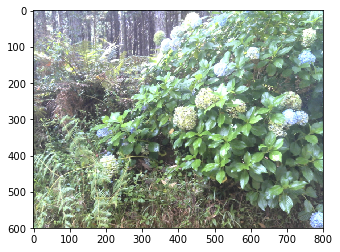

In [17]:
import matplotlib.pyplot as plt
plt.imshow(train_img[256])
plt.show()

In [18]:
def train_model_k_folds(model, train_data, train_label, model_out,  model_init_weights, epochs, kfolds):
    batch_size = 32
    kf = model_selection.KFold(n_splits=kfolds, shuffle=True)
    score_func = metrics.roc_auc_score

    i = 0
    models_stats = {}
    for train_ixs, valid_ixs in kf.split(train_data):
        x_train = train_data[train_ixs]
        x_valid = train_data[valid_ixs]
        y_train = train_label[train_ixs]
        y_valid = train_label[valid_ixs]

        gen = ImageDataGenerator(
            rotation_range = 30,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode = 'nearest')
        
        #re-initialzie the weights of the model on each run
        model.load_weights(model_init_weights)
        model_out_file = '/scratch/yns207/data_invasive/{}_{}.model'.format(model_out, str(i))
        model_checkpoint = ModelCheckpoint(model_out_file, 
                                            monitor='val_loss', 
                                            save_best_only=True)
        early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, mode='auto')

        hist = model.fit_generator(gen.flow(x_train, y_train, batch_size=batch_size),
                            steps_per_epoch=(len(x_train)//batch_size)+1,
                            validation_data=(x_valid,y_valid),
                            validation_steps=(len(x_valid)//batch_size)+1,
                            epochs=epochs,
                            verbose=1,
                            callbacks=[early_stopping, model_checkpoint])
        
        model.load_weights(model_out_file)
        
        eval_tr = model.evaluate(x_train, y_train)
        eval_va = model.evaluate(x_valid, y_valid)
        
        tr_score = score_func(y_train, model.predict(x_train)[:, 0])
        va_score = score_func(y_valid, model.predict(x_valid)[:, 0])
        
        print('\n')
        print('kfold: {}'.format(str(i)))
        print('best model train acc: {}, loss: {}'.format(eval_tr[1], eval_tr[0]))
        print('best model valid acc: {}, loss: {}'.format(eval_va[1], eval_va[0]))
        print('best model train aroc score: {}, valid aroc score: {}'.format(tr_score, va_score))
        print('\n')
        models_stats[model_out_file] = {'score_tr_va':[tr_score, va_score], 'train_acc_loss':[eval_tr[1], eval_tr[0]], 'val_acc_loss':[eval_va[1], eval_va[0]]}
        i += 1
        
        with open(os.path.join(models_path,'{}_{}'.format(model_out,history)), 'a') as f:
            f.write('kfold: {}'.format(str(i)))
            f.write('best model train acc: {}, loss: {}'.format(eval_tr[1], eval_tr[0]))
            f.write('best model valid acc: {}, loss: {}'.format(eval_va[1], eval_va[0]))
            f.write('best model train aroc score: {}, valid aroc score: {}'.format(tr_score, va_score))
            f.write('\n')
    
    return models_stats

# so what's dif this time?

1 - inception modules, this is an inception net

2 - deeper, ive added extra layers with the same filter depth at 128 and 512 to increase semantic complexity

3 - bigger images, 600 x 800 instead of 300 x 400

4 - 2 gpus. (Still dont have, cant get above parallelization code to work)

5 - faster lr

6 - 25 rounds of optimization

In [19]:
model = make_model((600,800,3), grab_optimizer('adam', 0.0025))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 600, 800, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 600, 800, 3)   12          input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 299, 399, 32)  896         batch_normalization_1[0][0]      
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, 299, 399, 32)  128         conv2d_1[0][0]                   
___________________________________________________________________________________________

In [20]:
%cd $DATA_DIR
# save initial weights for use on each kfolds run
model.save_weights('{}_base.model'.format(model_name))
# run kfolds 10x
models_stats = train_model_k_folds(model, train_img, train_label, model_name, '{}_base.model'.format(model_name), 25, 10)

/scratch/yns207/data_invasive
Epoch 1/25


ResourceExhaustedError: OOM when allocating tensor with shape[32,148,198,100]
	 [[Node: gradients/concatenate_2/concat_grad/Slice = Slice[Index=DT_INT32, T=DT_FLOAT, _class=["loc:@concatenate_2/concat"], _device="/job:localhost/replica:0/task:0/gpu:0"](gradients/global_average_pooling2d_1/Mean_grad/truediv, gradients/concatenate_2/concat_grad/ConcatOffset, gradients/concatenate_2/concat_grad/ShapeN)]]

Caused by op 'gradients/concatenate_2/concat_grad/Slice', defined at:
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2683, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2787, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-e7c870ea2602>", line 5, in <module>
    models_stats = train_model_k_folds(model, train_img, train_label, model_name, '{}_base.model'.format(model_name), 25, 10)
  File "<ipython-input-18-96ae4052282b>", line 38, in train_model_k_folds
    callbacks=[early_stopping, model_checkpoint])
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/keras/legacy/interfaces.py", line 88, in wrapper
    return func(*args, **kwargs)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/keras/engine/training.py", line 1787, in fit_generator
    self._make_train_function()
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/keras/engine/training.py", line 1013, in _make_train_function
    self.total_loss)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/keras/optimizers.py", line 381, in get_updates
    grads = self.get_gradients(loss, params)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/keras/optimizers.py", line 47, in get_gradients
    grads = K.gradients(loss, params)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 2264, in gradients
    return tf.gradients(loss, variables, colocate_gradients_with_ops=True)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 560, in gradients
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 368, in _MaybeCompile
    return grad_fn()  # Exit early
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 560, in <lambda>
    grad_scope, op, func_call, lambda: grad_fn(op, *out_grads))
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/ops/array_grad.py", line 194, in _ConcatGradV2
    op, grad, start_value_index=0, end_value_index=-1, dim_index=-1)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/ops/array_grad.py", line 126, in _ConcatGradHelper
    out_grads.append(array_ops.slice(grad, begin, size))
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 545, in slice
    return gen_array_ops._slice(input_, begin, size, name=name)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2933, in _slice
    name=name)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'concatenate_2/concat', defined at:
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2847, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-b8f64b9b7ffb>", line 1, in <module>
    model = make_model((600,800,3), grab_optimizer('adam', 0.0025))
  File "<ipython-input-10-cd8201af1d8e>", line 14, in make_model
    m = inception_block(100, m)
  File "<ipython-input-6-f93d088f7d2e>", line 9, in inception_block
    return concatenate([tower_1, tower_2, tower_3], axis=3)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/keras/layers/merge.py", line 508, in concatenate
    return Concatenate(axis=axis, **kwargs)(inputs)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/keras/engine/topology.py", line 585, in __call__
    output = self.call(inputs, **kwargs)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/keras/layers/merge.py", line 283, in call
    return K.concatenate(inputs, axis=self.axis)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1681, in concatenate
    return tf.concat([to_dense(x) for x in tensors], axis)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1034, in concat
    name=name)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 519, in _concat_v2
    name=name)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/yns207/anaconda3/envs/keras-py3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[32,148,198,100]
	 [[Node: gradients/concatenate_2/concat_grad/Slice = Slice[Index=DT_INT32, T=DT_FLOAT, _class=["loc:@concatenate_2/concat"], _device="/job:localhost/replica:0/task:0/gpu:0"](gradients/global_average_pooling2d_1/Mean_grad/truediv, gradients/concatenate_2/concat_grad/ConcatOffset, gradients/concatenate_2/concat_grad/ShapeN)]]


In [ ]:
models_stats

In [ ]:
subm = test_set.iloc[:]
subm = subm.drop('invasive',1)

%cd $DATA_DIR
models = [1,3,4,5,6,7]
model = make_model((300,400,3), grab_optimizer('adam', 0.00025))

for f in models:
    model.load_weights('{}_{}.model'.format(model_name, str(f)))
    subm[str(f)] = make_preds(model, test_img)['invasive']
subm.head()

In [ ]:
subm['invasive'] = subm[[str(f) for f in models]].mean(axis=1)
subm = subm.drop([str(f) for f in models], 1)
subm.head()

In [ ]:
subm.to_csv(os.path.join(DATA_DIR, 'results', 'subm_jun_27_17_0.gz'), index=False, compression='gzip')

In [ ]:
from scipy.stats import rankdata
from sklearn.preprocessing import MinMaxScaler

In [ ]:
subm = test_set.iloc[:]
subm = subm.drop('invasive',1)

%cd $DATA_DIR
models = [1,3,4,5,6,7]
model = make_model((300,400,3), grab_optimizer('adam', 0.00025))

for f in models:
    model.load_weights('{}_{}.model'.format(model_name, str(f)))
    subm[str(f)] = make_preds(model, test_img)['invasive']
subm.head()

In [ ]:
for f in models:
    subm['r'+str(f)] = rankdata(subm[str(f)])
subm.head()

In [ ]:
subm['r_avg'] = subm[['r1','r3','r4','r5','r6','r7']].mean(axis=1)
subm.head()

In [ ]:
subm['final_r_blend'] = MinMaxScaler().fit_transform(subm['r_avg'].reshape(-1, 1))

In [ ]:
subm.head()

In [ ]:
subm = subm[['name', 'final_r_blend']]
subm.head()

In [ ]:
subm.to_csv(os.path.join(DATA_DIR, 'results', 'subm_jun_27_17_1.gz'), index=False, compression='gzip')

ok that had the exact same 0.984 score, LOL that's because the submission NEVER WENT THROUGH, i accidentally submitted the older file, my mistake, if it had gone through the column name is not invasive here so it would haev trhown an error

In [ ]:
%cd $DATA_DIR
_, test_img_22, _ = read_imgs(128,128)
_, test_img_23_24, _ = read_imgs(300,400)

In [ ]:
# lets try one more ensemble with 3 best conv models, the 3 best resnet models

subm = test_set.iloc[:]
subm = subm.drop('invasive',1)

# 3 best conv models,
# best resnet models, (omitting model 1)
models = [
        'model_jun23_kfold_3.model',
        'model_jun23_kfold_7.model',
        'model_jun23_kfold_9.model',
        'model_jun25_kfold_3.model',
        'model_jun25_kfold_4.model',
        'model_jun25_kfold_5.model',
        'model_jun25_kfold_6.model',
        'model_jun25_kfold_7.model'
        ]

In [ ]:
def conv_block(filter_depth, filter_size, pool_size, activation, inputs):
    x = BatchNormalization()(inputs)
    x = Convolution2D(filter_depth, filter_size, activation=activation)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    return x

def dense_block(units, activation, drop_prob, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=activation)(x)
    x = Dropout(drop_prob)(x)
    return x

def make_model_23(input_shape, optimizer):
    inputs = Input(shape=input_shape)
    m = conv_block(16, (3,3), (2,2),'relu', inputs=inputs)
    m = conv_block(32, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(64, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(128, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(256, (3,3), (2,2), 'relu', inputs=m)
    m = Flatten()(m)
    m = dense_block(2048, 'relu', 0.25, inputs=m)
    m = dense_block(512, 'relu', 0.5, inputs=m)
    outputs = dense_block(1, 'sigmoid', 0, inputs=m)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def conv_block(filter_depth, filter_size, pool_size, activation, inputs):
    x = BatchNormalization()(inputs)
    x = Convolution2D(filter_depth, filter_size, activation=activation)(x)
    x = MaxPooling2D(pool_size=pool_size)(x)
    return x

def dense_block(units, activation, drop_prob, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=activation)(x)
    x = Dropout(drop_prob)(x)
    return x

def make_model_22(input_shape, optimizer):
    inputs = Input(shape=input_shape)
    m = conv_block(16, (3,3), (2,2),'relu', inputs=inputs)
    m = conv_block(32, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(64, (3,3), (2,2), 'relu', inputs=m)
    m = conv_block(128, (3,3), (2,2), 'relu', inputs=m)
    m = Flatten()(m)
    m = dense_block(2048, 'relu', 0.55, inputs=m)
    m = dense_block(512, 'relu', 0.65, inputs=m)
    outputs = dense_block(1, 'sigmoid', 0, inputs=m)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

def dense_block(units, activation, drop_prob, inputs):
    x = BatchNormalization()(inputs)
    x = Dense(units, activation=activation)(x)
    x = Dropout(drop_prob)(x)
    return x

#my attempt at making a resnet identity block, wont be making any conv block
def resnet_block(filter_depth, filter_size, pool_size, activation, inputs):
    x = BatchNormalization()(inputs)
    x = Convolution2D(filter_depth, (1,1), activation=activation)(x)

    x = BatchNormalization()(x)
    x = Convolution2D(filter_depth, filter_size, activation=activation, padding='same')(x)
    
    x = BatchNormalization()(x)
    x = Convolution2D(filter_depth, (1,1))(x)
    
    shortcut = Convolution2D(filter_depth, (1,1))(inputs)
    shortcut = BatchNormalization()(shortcut)
    
    x = keras.layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def make_model_25(input_shape, optimizer):
    inputs = Input(shape=input_shape)
    m = ZeroPadding2D((3,3))(inputs)
    m = Convolution2D(16, (3,3), strides=(2,2), activation='relu')(m)
    m = MaxPooling2D((3,3), strides=(2,2))(m)
    m = resnet_block(32, (3,3), (2,2), 'relu', inputs=m)
    m = resnet_block(64, (3,3), (2,2), 'relu', inputs=m)
    m = resnet_block(128, (3,3), (2,2), 'relu', inputs=m)
    m = AveragePooling2D((7, 7))(m)
    m = Flatten()(m)
    m = dense_block(2048, 'relu', 0.25, inputs=m)
    m = dense_block(512, 'relu', 0.5, inputs=m)
    outputs = dense_block(1, 'sigmoid', 0, inputs=m)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

#omitted 24 because it was just a poorly performing resnet50
model_23 = make_model_23((300,400,3), grab_optimizer('adam', 0.000125))
model_25 = make_model_25((300,400,3), grab_optimizer('adam', 0.0005))

for f in models:
    if 'jun23' in f:
        model_23.load_weights(f)
        model_test = model_23
        subm[str(f)] = make_preds(model_test, test_img_23_24)['invasive']
    else:
        model_25.load_weights(f)
        model_test = model_25
        subm[str(f)] = make_preds(model_test, test_img_23_24)['invasive']
subm.head()

In [ ]:
for f in models:
    subm['r_'+str(f)] = rankdata(subm[str(f)])
subm.head()

In [ ]:
subm['r_avg'] = subm[['r_'+f for f in models]].mean(axis=1)
subm.head()

In [ ]:
subm['final_r_blend'] = MinMaxScaler().fit_transform(subm['r_avg'].reshape(-1, 1))

In [ ]:
subm.head()

In [ ]:
subm = subm[['name', 'final_r_blend']]
subm.columns = ['name', 'invasive']
subm.head()

In [ ]:
subm.to_csv(os.path.join(DATA_DIR, 'results', 'subm_jun_27_17_2.gz'), index=False, compression='gzip')

alright well that rank average did improve my score, 0.98526 -> 0.98560, this ensemble is maybe worth building off of.

# summary

http://blog.kaggle.com/2017/04/20/dogs-vs-cats-redux-playground-competition-3rd-place-interview-marco-lugo/

https://gogul09.github.io/software/flower-recognition

good overview of voting/rank averraging ensembles:

http://andremeetsdata.com/2015/12/30/Numerai-Averaging

https://mlwave.com/kaggle-ensembling-guide/

https://www.kaggle.com/c/homesite-quote-conversion/discussion/18067

giving extra number after the decimal may hust us? worth investigating, or it could have no effect on receiver curve.

will try:

resnet: https://ctmakro.github.io/site/on_learning/resnet_keras.html

simplenet: https://arxiv.org/pdf/1608.06037.pdf

leaky relu: https://keras.io/layers/advanced-activations/

this site has desciptions for voting ensembles, cool: https://mlwave.com/kaggle-ensembling-guide/

in combinatio with my convolutional ensemble from before.